In [87]:
7.069259
7.069259000000001
otherbool = (7.069259 == 7.069259000000001)
print(otherbool)
bool = math.isclose(7.069259, 7.069259000000001,  rel_tol=1e-16, abs_tol=0.0)
bool
test = curve_length(1, 7.069259, 5, 7.069259, 3)
test

False


ZeroDivisionError: float division by zero

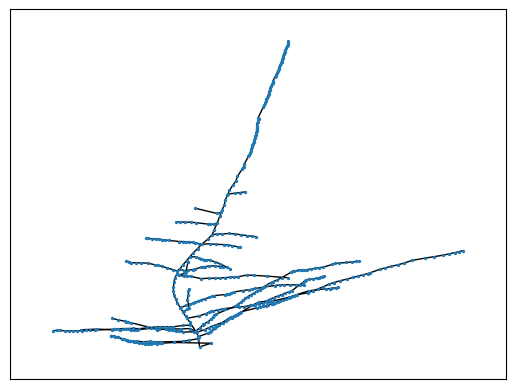

In [104]:
G = rar.read_arbor_full('001_1_c_day5.csv')
coords = {}
for coordinate in list(G.nodes):
    coords[coordinate] = coordinate
nx.draw_networkx(G, pos = coords, with_labels = False, node_size = 2)

In [5]:
import math
import point_similarity as ps
import scipy.integrate as integrate
import pylab
import mpmath
#from scipy.misc import derivative
import plotly
from plotly import graph_objs as go
import sys
import read_arbor_reconstruction as rar
import networkx as nx
import pareto_functions as pf
from constants import *
import os
import pickle
import argparse
import pandas as pd
## returns the coefficients of the quadratic equation involving gravity
def calc_coeff(G, x, y, p, q):
    b = ((q - y - G*(p*p - x*x))/(p-x))
    c = (q - G*p*p - b*p)

    # assert (G * x * x) + (b * x) + c == y
    # assert (G * p * p) + (b * p) + c == q

    return b, c

## checks if a line has a positive slope given two points
def positive_slope(x0, y0, x1, y1):
    if x0 == x1 or y0 == y1:
        return False
    slope = (y1 - y0)/(x1 - x0)
    if slope >= 0:
        return True
    return False

## simply just a distance function
def length_func(x0, y0, x1, y1):
    length = pylab.sqrt((x1 - x0)**2 + (y1 - y0)**2)
    return length

## a way to calculate theta based on two points
def get_theta(x0, y0, x1, y1):
    if x1 == x0 or y1 == y0:
        return 0
    theta = pylab.arctan((abs(y1 - y0))/(abs(x1 - x0)))
    return theta

## Returns the length of a curve (in this case a lateral root when gravity is not 0)
def curve_length(G, x0, y0, p, q):
    b, c = calc_coeff(G, x0, y0, p, q)
    def differential(x):
        return pylab.sqrt(1 + (2*G*x + b)**2)
    curve, tolerance = integrate.quad(differential, min(x0, p), max(x0, p))
    return curve

## Returns the distance from a point to the base of the plant
def distance_from_base(root_distance, x, y, x1, y1):
    pair1 = [x, y]
    pair2 = [x1, y1]
    distance = math.dist(pair1, pair2)
    if(x,y) == (x1, y1):
        assert distance == 0
    return distance + root_distance

## Returns the total cost along with the wiring and delay used to calculate it
def total_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q):
    curve = curve_length(G, x1, y1, p, q)
    to_root = distance_from_base(root_distance, x0, y0, x1, y1)
    wiring = curve
    delay = (curve + to_root)
    cost = (alpha * wiring) +  ((1 - alpha) * delay)
    #print("curve = ", curve, "to root = " , to_root, "wiring = ", wiring, "delay = ", delay, "total cost = ", cost)
    #cost = curve + (1 - alpha) * distance_from_base(root_distance, x0, y0, x1, y1)
    return cost, wiring, delay

def find_best_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q):
    results = []
    min_t = 0
    delta = 0.01
    max_t = 1
    best_t = math.inf
    best_cost = math.inf
    best_wiring = math.inf
    best_delay = math.inf
    l = length_func(x0, y0, x1, y1)
    theta = get_theta(x0, y0, x1, y1)
    x_opt = None
    y_opt = None
    best_x = None
    best_y = None
    for t in pylab.arange(min_t, max_t + delta, delta):
        is_positive = positive_slope(x0, y0, x1, y1)
        new_x = None
        new_y = None
        if is_positive:
            new_x = x0 + t*l*math.cos(theta)
            new_y = y0 + t*l*math.sin(theta)
        else:
            new_x = x0 - (t*l*math.cos(theta))
            new_y = y0 + (t*l*math.sin(theta))
        x_curr = pylab.linspace(min(p, new_x), max(p, new_x))
        cost, wiring, delay = total_cost(alpha, G, root_distance, x0, y0, new_x, new_y, p, q)
        if cost <= best_cost:
            best_cost = cost
            best_wiring = wiring
            best_delay = delay
            best_t = t
            b, c = calc_coeff(G, new_x, new_y, p, q)
            best_x = new_x
            best_y = new_y
            #x_opt = x_curr
            #y_opt = G * x_opt ** 2 + b * x_opt + c
        '''
        if t % 0.2 == 0:
            b, c = calc_coeff(G, new_x, new_y, p, q)
            y_inter =  G * x_curr ** 2 + b * x_curr + c
            intermediate_line = go.Scatter(x = x_curr,y = y_inter, mode = "lines", name = str(cost))
            fig.add_trace(intermediate_line)
           '''
        results.append(cost)
    ##opt_line = go.Scatter(x = x_opt, y = y_opt, mode = "lines", name = "Optimal: " + str(best_cost))
    ##fig.add_trace(opt_line)
    return best_cost, best_wiring, best_delay, best_t, best_x, best_y, p, q

def arbor_best_cost(fname, alpha, G, root_distance):
    arbor = rar.read_arbor_full(fname)
    main_root = []
    lat_tips = []
    line_segments = {}
    point_drawing = go.Figure()
    for node in arbor.nodes():
        if arbor.nodes[node]["label"] == ("main root") or arbor.nodes[node]["label"] == ("main root base"):
            main_root.append(node)
        if arbor.nodes[node]["label"] == ("lateral root tip"):
            lat_tips.append(node)
    for i in range(1, len(main_root)):
        line_segments[i] = main_root[i - 1], main_root[i]

    # for each lateral root tip iterate through every line segment to find lowest costing point on main root
    final = []
    for tip in lat_tips:
        curr_dist = 0
        results = []
        firstTime = True
        p = tip[0]
        q = tip[1]
        for seg in line_segments:
            x0 = line_segments[seg][0][0]
            y0 = line_segments[seg][0][1]
            x1 = line_segments[seg][1][0]
            y1 = line_segments[seg][1][1]
            if firstTime == True:
                result = find_best_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q)
                curr_dist += length_func(x0, y0, x1, y1)
                firstTime = False
            else:
                result = find_best_cost(alpha, G, root_distance + curr_dist, x0, y0, x1, y1, p, q)
                curr_dist += length_func(x0, y0, x1, y1)
            results.append(result)
        final.append(min(results))

    return final


def get_last_day_files():
    files_by_genotype = {}

    for file_name in os.listdir(RECONSTRUCTIONS_DIR):
        if not file_name.endswith(".csv"):
            continue
        parts = file_name.split('_')

        genotype = parts[0]
        replicate = parts[1]
        condition = parts[2]
        hormone = None
        if len(parts) >= 3:
            hormone = parts[3]
        day = parts[-1].replace('.csv', '')
        day = int(day.strip('day'))

        key = (genotype, replicate, condition)
        if key not in files_by_genotype:
            files_by_genotype[key] = {}

        files_by_genotype[key][day] = file_name

    last_day_files = {}
    for key, day_files in files_by_genotype.items():
        last_day = max(day_files.keys())
        if last_day not in [5, 9]:
            continue
        last_day_files[key] = day_files[last_day]
    return last_day_files

def is_between(a, x, b):
        return a < x < b or b < x < a


def get_closest_main_seg(lat_tips, line_segments):
    closest_segs = []
    for tip in lat_tips: 
        best_distance = math.inf
        best_seg = None
        for num, seg in line_segments.items():
            d = math.inf
            x0, y0 = seg[0]
            x1, y1 = seg[1]

            A = (x0 - tip[0]) * (x1 - x0) + (y0 - tip[1]) * (y1 - y0)
            B = (x1 - x0)**2 + (y1 - y0)**2
            t = A/B
            if (0 <= t <= 1): 
                c = abs(((x1 - x0) * (y0 - tip[1])) - ((y1 - y0) * (x0 - tip[0])))
                d = c/math.sqrt(B)
            else: 
                d1 = math.sqrt((x1-tip[0])**2 + (y1 - tip[1])**2)
                d2 = math.sqrt((x0-tip[0])**2 + (y0 - tip[1])**2)
                d = min(d1, d2)
            if d < best_distance:
                best_distance = d
                best_seg = seg
        closest_segs += best_seg
    return closest_segs


# this code returns segments on the main root that don't have a y coordinate higher than the closest main root segment
def valid_segments(tip_number, line_segments, closest_segs):
    valid_segs = []
    for seg in line_segments:
        y = seg[1]
        closest = closest_segs[tip_number]
        closest_y = closest[1]
        if y < closest_y:
            valid_segs += seg
        else:
            break
    return valid_segs
        

In [2]:
import math
import point_similarity as ps
import scipy.integrate as integrate
import pylab
import mpmath
#from scipy.misc import derivative
import plotly
from plotly import graph_objs as go
import sys
import read_arbor_reconstruction as rar
import networkx as nx
import pareto_functions as pf
from constants import *
import os
import pickle
import argparse
import pandas as pd
## returns the coefficients of the quadratic equation involving gravity
def calc_coeff(G, x, y, p, q):
    b = ((q - y - G*(p*p - x*x))/(p-x))
    c = (q - G*p*p - b*p)

    # assert (G * x * x) + (b * x) + c == y
    # assert (G * p * p) + (b * p) + c == q

    return b, c

## checks if a line has a positive slope given two points
def positive_slope(x0, y0, x1, y1):
    if x0 == x1 or y0 == y1:
        return False
    slope = (y1 - y0)/(x1 - x0)
    if slope >= 0:
        return True
    return False

## simply just a distance function
def length_func(x0, y0, x1, y1):
    length = pylab.sqrt((x1 - x0)**2 + (y1 - y0)**2)
    return length

## a way to calculate theta based on two points
def get_theta(x0, y0, x1, y1):
    if x1 == x0 or y1 == y0:
        return 0
    theta = pylab.arctan((abs(y1 - y0))/(abs(x1 - x0)))
    return theta

## Returns the length of a curve (in this case a lateral root when gravity is not 0)
def curve_length(G, x0, y0, p, q):
    b, c = calc_coeff(G, x0, y0, p, q)
    def differential(x):
        return pylab.sqrt(1 + (2*G*x + b)**2)
    curve, tolerance = integrate.quad(differential, min(x0, p), max(x0, p))
    return curve

## Returns the distance from a point to the base of the plant
def distance_from_base(root_distance, x, y, x1, y1):
    pair1 = [x, y]
    pair2 = [x1, y1]
    distance = math.dist(pair1, pair2)
    if(x,y) == (x1, y1):
        assert distance == 0
    return distance + root_distance

## Returns the total cost along with the wiring and delay used to calculate it
def total_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q):
    curve = curve_length(G, x1, y1, p, q)
    to_root = distance_from_base(root_distance, x0, y0, x1, y1)
    wiring = curve
    delay = (curve + to_root)
    cost = (alpha * wiring) +  ((1 - alpha) * delay)
    #print("curve = ", curve, "to root = " , to_root, "wiring = ", wiring, "delay = ", delay, "total cost = ", cost)
    #cost = curve + (1 - alpha) * distance_from_base(root_distance, x0, y0, x1, y1)
    return cost, wiring, delay

def find_best_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q):
    results = []
    min_t = 0
    delta = 0.01
    max_t = 1
    best_t = math.inf
    best_cost = math.inf
    best_wiring = math.inf
    best_delay = math.inf
    l = length_func(x0, y0, x1, y1)
    theta = get_theta(x0, y0, x1, y1)
    x_opt = None
    y_opt = None
    best_x = None
    best_y = None
    for t in pylab.arange(min_t, max_t + delta, delta):
        is_positive = positive_slope(x0, y0, x1, y1)
        new_x = None
        new_y = None
        if is_positive:
            new_x = x0 + t*l*math.cos(theta)
            new_y = y0 + t*l*math.sin(theta)
        else:
            new_x = x0 - (t*l*math.cos(theta))
            new_y = y0 + (t*l*math.sin(theta))
        x_curr = pylab.linspace(min(p, new_x), max(p, new_x))
        cost, wiring, delay = total_cost(alpha, G, root_distance, x0, y0, new_x, new_y, p, q)
        if cost <= best_cost:
            best_cost = cost
            best_wiring = wiring
            best_delay = delay
            best_t = t
            b, c = calc_coeff(G, new_x, new_y, p, q)
            best_x = new_x
            best_y = new_y
            #x_opt = x_curr
            #y_opt = G * x_opt ** 2 + b * x_opt + c
        '''
        if t % 0.2 == 0:
            b, c = calc_coeff(G, new_x, new_y, p, q)
            y_inter =  G * x_curr ** 2 + b * x_curr + c
            intermediate_line = go.Scatter(x = x_curr,y = y_inter, mode = "lines", name = str(cost))
            fig.add_trace(intermediate_line)
           '''
        results.append(cost)
    ##opt_line = go.Scatter(x = x_opt, y = y_opt, mode = "lines", name = "Optimal: " + str(best_cost))
    ##fig.add_trace(opt_line)
    return best_cost, best_wiring, best_delay, best_t, best_x, best_y, p, q

def arbor_best_cost(fname, alpha, G, root_distance):
    arbor = rar.read_arbor_full(fname)
    main_root = []
    lat_tips = []
    line_segments = {}
    point_drawing = go.Figure()
    for node in arbor.nodes():
        if arbor.nodes[node]["label"] == ("main root") or arbor.nodes[node]["label"] == ("main root base"):
            main_root.append(node)
        if arbor.nodes[node]["label"] == ("lateral root tip"):
            lat_tips.append(node)
    for i in range(1, len(main_root)):
        line_segments[i] = main_root[i - 1], main_root[i]

    # for each lateral root tip iterate through every line segment to find lowest costing point on main root
    final = []
    for tip in lat_tips:
        curr_dist = 0
        results = []
        firstTime = True
        p = tip[0]
        q = tip[1]
        for seg in line_segments:
            x0 = line_segments[seg][0][0]
            y0 = line_segments[seg][0][1]
            x1 = line_segments[seg][1][0]
            y1 = line_segments[seg][1][1]
            if firstTime == True:
                result = find_best_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q)
                curr_dist += length_func(x0, y0, x1, y1)
                firstTime = False
            else:
                result = find_best_cost(alpha, G, root_distance + curr_dist, x0, y0, x1, y1, p, q)
                curr_dist += length_func(x0, y0, x1, y1)
            results.append(result)
        final.append(min(results))

    return final


def get_last_day_files():
    files_by_genotype = {}

    for file_name in os.listdir(RECONSTRUCTIONS_DIR):
        if not file_name.endswith(".csv"):
            continue
        parts = file_name.split('_')

        genotype = parts[0]
        replicate = parts[1]
        condition = parts[2]
        hormone = None
        if len(parts) >= 3:
            hormone = parts[3]
        day = parts[-1].replace('.csv', '')
        day = int(day.strip('day'))

        key = (genotype, replicate, condition)
        if key not in files_by_genotype:
            files_by_genotype[key] = {}

        files_by_genotype[key][day] = file_name

    last_day_files = {}
    for key, day_files in files_by_genotype.items():
        last_day = max(day_files.keys())
        if last_day not in [5, 9]:
            continue
        last_day_files[key] = day_files[last_day]
    return last_day_files

def is_between(a, x, b):
        return a < x < b or b < x < a


last_day = get_last_day_files()
count = 0
for key,arbor in last_day.items():
    #print(arbor)
    arbor_test = rar.read_arbor_full(arbor)
    main_root = []
    lat_tips = []
    line_segments = {}
    #point_drawing = go.Figure()
    for node in arbor_test.nodes():
        if arbor_test.nodes[node]["label"] == ("main root") or arbor_test.nodes[node]["label"] == ("main root base"):
            main_root.append(node)
        if arbor_test.nodes[node]["label"] == ("lateral root tip"):
            lat_tips.append(node)
    for i in range(1, len(main_root)):
        line_segments[i] = main_root[i - 1], main_root[i]


    ## This code returns the closest main root segment for each lateral root tip
    closest_segs = []
    for tip in lat_tips: 
        best_distance = math.inf
        best_seg = None
        for num, seg in line_segments.items():
            d = math.inf
            x0, y0 = seg[0]
            x1, y1 = seg[1]

            A = (x0 - tip[0]) * (x1 - x0) + (y0 - tip[1]) * (y1 - y0)
            B = (x1 - x0)**2 + (y1 - y0)**2
            t = A/B
            if (0 <= t <= 1): 
                c = abs(((x1 - x0) * (y0 - tip[1])) - ((y1 - y0) * (x0 - tip[0])))
                d = c/math.sqrt(B)
            else: 
                d1 = math.sqrt((x1-tip[0])**2 + (y1 - tip[1])**2)
                d2 = math.sqrt((x0-tip[0])**2 + (y0 - tip[1])**2)
                d = min(d1, d2)
            if d < best_distance:
                best_distance = d
                best_seg = seg
            


        closest_segs += best_seg
        #print("Tip " + str(tip) + " closest segment is " + str(best_seg) + " with distance: " + str(best_distance))
    #print(closest_segs)

# created helper function based on code above
def get_closest_main_seg(lat_tips, line_segments):
    closest_segs = []
    for tip in lat_tips: 
        best_distance = math.inf
        best_seg = None
        for num, seg in line_segments.items():
            d = math.inf
            x0, y0 = seg[0]
            x1, y1 = seg[1]

            A = (x0 - tip[0]) * (x1 - x0) + (y0 - tip[1]) * (y1 - y0)
            B = (x1 - x0)**2 + (y1 - y0)**2
            t = A/B
            if (0 <= t <= 1): 
                c = abs(((x1 - x0) * (y0 - tip[1])) - ((y1 - y0) * (x0 - tip[0])))
                d = c/math.sqrt(B)
            else: 
                d1 = math.sqrt((x1-tip[0])**2 + (y1 - tip[1])**2)
                d2 = math.sqrt((x0-tip[0])**2 + (y0 - tip[1])**2)
                d = min(d1, d2)
            if d < best_distance:
                best_distance = d
                best_seg = seg
        closest_segs += best_seg
    return closest_segs


# this code returns segments on the main root that don't have a y coordinate higher than the closest main root segment
def valid_segments(tip_number, line_segments, closest_segs):
    valid_segs = []
    for seg in line_segments:
        y = seg[1]
        closest = closest_segs[tip_number]
        closest_y = closest[1]
        if y < closest_y:
            valid_segs += seg
        else:
            break
    return valid_segs
        

def modified_arbor_best_cost(fname, alpha, G, root_distance):
    final = []
    arbor = rar.read_arbor_full(fname)
    main_root = []
    lat_tips = []
    line_segments = {}
    #point_drawing = go.Figure()
    for node in arbor.nodes():
        if arbor.nodes[node]["label"] == ("main root") or arbor.nodes[node]["label"] == ("main root base"):
            main_root.append(node)
        if arbor.nodes[node]["label"] == ("lateral root tip"):
            lat_tips.append(node)
    for i in range(1, len(main_root)):
        line_segments[i] = main_root[i - 1], main_root[i]

    closest_segs = get_closest_main_seg(lat_tips, line_segments)
    tip_number = 0
    for tip in lat_tips: 
        curr_dist = 0
        results = []
        valid_segs = valid_segments(tip_number, line_segments, closest_segs)
        for seg in valid_segs: 
            x0, y0 = seg[0]
            x1, y1 = seg[1]
            # if the tip is in between a segment, brute force the segment
            if is_between(x0, tip[0], x1):
                if firstTime == True:
                    result = find_best_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q)
                    curr_dist += length_func(x0, y0, x1, y1)
                    firstTime = False
                else:
                    result = find_best_cost(alpha, G, root_distance + curr_dist, x0, y0, x1, y1, p, q)
                    curr_dist += length_func(x0, y0, x1, y1)
                results.append(result)
            # if the tip is not in between a segment, use Dr. Richard's equation
            else:
                l = math.sqrt((x1 - x0)**2 + (y1 - y0)**2)
                theta = math.atan2(y1 - y0, x1 - x0)

                # Recalculate A1–E1 based on current l, theta, G, p, q
                A1 = G * (l * math.cos(theta))**2
                B1 = -l * math.sin(theta)
                C1 = q - G * p**2
                D1 = -l * math.cos(theta)
                E1 = p
            
                # Define b(t), b'(t), cost'(t)
                def b(t): return (A1*t**2 + B1*t + C1) / (D1*t + E1)
                def bprime(t):
                    numerator = (D1*t + E1)*(2*A1*t + B1) - D1*(A1*t**2 + B1*t + C1)
                    denominator = (D1*t + E1)**2
                    return numerator / denominator
                def costprime(t):
                    b_val = b(t)
                    bp = bprime(t)
                    term1 = (bp / (2 * G)) * (math.sqrt(1 + (2 * G * p + b_val)**2) -
                                               math.sqrt(1 + (2 * G * t * l * math.cos(theta) + b_val)**2))
                    term2 = (1 - alpha) * l
                    term3 = math.sqrt(1 + (2 * G * t * l * math.cos(theta) + b_val)**2) * l * math.cos(theta)
                    return term1 + term2 - term3
            
                # Find root(s) of costprime in [0, 1]
                roots = find_multiple_roots(costprime, [0, 1], num_guesses=200)
                valid_roots = [r for r in roots if 0 <= r <= 1]
            
                # Define the full cost function if not already
                def cost(t):
                    b_val = b(t)
                    return ((1 - alpha) * l * t + alpha / (2 * G) *
                            (math.sqrt(1 + (2 * G * p + b_val)**2) -
                             math.sqrt(1 + (2 * G * t * l * math.cos(theta) + b_val)**2)))
            
                # Get cost at valid root(s)
                if valid_roots:
                    min_root = min(valid_roots, key=lambda t: cost(t))
                    result = cost(min_root)
                    results.append(result)
                
        final.append(min(results))
        tip_number += 1

    return final


    # THIS IS FOR WHEN YOU WANT TO COUNT HOW MANY TIMES A TIP APPEARS IN BETWEEN A ROOT SEGMENT'S X COORDINATE
   # for num, seg in line_segments.items():
      #  x0, y0 = seg[0]
      #  x1, y1 = seg[1]
      #  min_t = 0
      #  delta = 0.01
      #  max_t = 1
      #  l = length_func(x0, y0, x1, y1)
       # theta = get_theta(x0, y0, x1, y1)
      #  for tip in lat_tips:
         #   if (x0 <= tip[0] <= x1):
          #      count += 1
            #    print(count)
            
      #  for t in pylab.arange(min_t, max_t + delta, delta):
            #for tip in lat_tips:
               # if is_between(x0, tip[0], x1):
                   # count += 1
                  #  print(count)

                
                #is_positive = positive_slope(x0, y0, x1, y1)
                #new_x = None
               # new_y = None
              #  if is_positive:
                 #   new_x = x0 + t*l*math.cos(theta)
                   # new_y = y0 + t*l*math.sin(theta)
               # else:
                 #   new_x = x0 - (t*l*math.cos(theta))
                   # new_y = y0 + (t*l*math.sin(theta))
                #if(math.isclose(tip[0], new_x, rel_tol=1e-9, abs_tol=0.0)):
                   # print(tip[0])
                   # print(new_x)
                  #  raise Exception("X-coordinates are the same. Vertical line test failed.")
                
                


KeyboardInterrupt



[((6.216466, 4.535322), (6.226423, 4.737842)), ((6.226423, 4.737842), (6.245008, 4.85934)), ((6.245008, 4.85934), (6.174974, 4.974765)), ((6.174974, 4.974765), (6.142084, 5.053255)), ((6.142084, 5.053255), (6.123158, 5.175507)), ((6.123158, 5.175507), (6.10373, 5.301015)), ((6.10373, 5.301015), (6.091752, 5.378411)), ((6.091752, 5.378411), (6.094696, 5.510375)), ((6.094696, 5.510375), (6.036667, 5.66764)), ((6.036667, 5.66764), (5.991576, 5.735586)), ((5.991576, 5.735586), (5.893041, 5.858559)), ((5.893041, 5.858559), (5.840053, 5.944022)), ((5.840053, 5.944022), (5.777653, 6.036696)), ((5.777653, 6.036696), (5.746139, 6.086179)), ((5.746139, 6.086179), (5.687519, 6.231828)), ((5.687519, 6.231828), (5.659779, 6.292732)), ((5.659779, 6.292732), (5.63137, 6.340664)), ((5.63137, 6.340664), (5.592516, 6.406215)), ((5.592516, 6.406215), (5.553662, 6.471765)), ((5.553662, 6.471765), (5.481818, 6.560254)), ((5.481818, 6.560254), (5.43335, 6.615202)), ((5.43335, 6.615202), (5.393803, 6.678135)

C:\Users\agarz\AppData\Local\Temp\ipykernel_6264\2249154271.py:208: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



[((6.216466, 4.535322), (6.226423, 4.737842)), ((6.226423, 4.737842), (6.245008, 4.85934)), ((6.245008, 4.85934), (6.174974, 4.974765)), ((6.174974, 4.974765), (6.142084, 5.053255)), ((6.142084, 5.053255), (6.123158, 5.175507)), ((6.123158, 5.175507), (6.10373, 5.301015)), ((6.10373, 5.301015), (6.091752, 5.378411)), ((6.091752, 5.378411), (6.094696, 5.510375)), ((6.094696, 5.510375), (6.036667, 5.66764))]
[((6.216466, 4.535322), (6.226423, 4.737842)), ((6.226423, 4.737842), (6.245008, 4.85934))]


C:\Users\agarz\AppData\Local\Temp\ipykernel_6264\2249154271.py:245: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



[((6.216466, 4.535322), (6.226423, 4.737842)), ((6.226423, 4.737842), (6.245008, 4.85934)), ((6.245008, 4.85934), (6.174974, 4.974765)), ((6.174974, 4.974765), (6.142084, 5.053255)), ((6.142084, 5.053255), (6.123158, 5.175507)), ((6.123158, 5.175507), (6.10373, 5.301015)), ((6.10373, 5.301015), (6.091752, 5.378411)), ((6.091752, 5.378411), (6.094696, 5.510375)), ((6.094696, 5.510375), (6.036667, 5.66764)), ((6.036667, 5.66764), (5.991576, 5.735586)), ((5.991576, 5.735586), (5.893041, 5.858559)), ((5.893041, 5.858559), (5.840053, 5.944022)), ((5.840053, 5.944022), (5.777653, 6.036696)), ((5.777653, 6.036696), (5.746139, 6.086179)), ((5.746139, 6.086179), (5.687519, 6.231828)), ((5.687519, 6.231828), (5.659779, 6.292732)), ((5.659779, 6.292732), (5.63137, 6.340664)), ((5.63137, 6.340664), (5.592516, 6.406215)), ((5.592516, 6.406215), (5.553662, 6.471765)), ((5.553662, 6.471765), (5.481818, 6.560254)), ((5.481818, 6.560254), (5.43335, 6.615202)), ((5.43335, 6.615202), (5.393803, 6.678135)

C:\Users\agarz\AppData\Local\Temp\ipykernel_6264\2249154271.py:245: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.



[((6.216466, 4.535322), (6.226423, 4.737842)), ((6.226423, 4.737842), (6.245008, 4.85934)), ((6.245008, 4.85934), (6.174974, 4.974765)), ((6.174974, 4.974765), (6.142084, 5.053255)), ((6.142084, 5.053255), (6.123158, 5.175507)), ((6.123158, 5.175507), (6.10373, 5.301015)), ((6.10373, 5.301015), (6.091752, 5.378411)), ((6.091752, 5.378411), (6.094696, 5.510375)), ((6.094696, 5.510375), (6.036667, 5.66764)), ((6.036667, 5.66764), (5.991576, 5.735586)), ((5.991576, 5.735586), (5.893041, 5.858559)), ((5.893041, 5.858559), (5.840053, 5.944022)), ((5.840053, 5.944022), (5.777653, 6.036696)), ((5.777653, 6.036696), (5.746139, 6.086179)), ((5.746139, 6.086179), (5.687519, 6.231828))]
[((6.216466, 4.535322), (6.226423, 4.737842)), ((6.226423, 4.737842), (6.245008, 4.85934)), ((6.245008, 4.85934), (6.174974, 4.974765)), ((6.174974, 4.974765), (6.142084, 5.053255)), ((6.142084, 5.053255), (6.123158, 5.175507)), ((6.123158, 5.175507), (6.10373, 5.301015)), ((6.10373, 5.301015), (6.091752, 5.378411

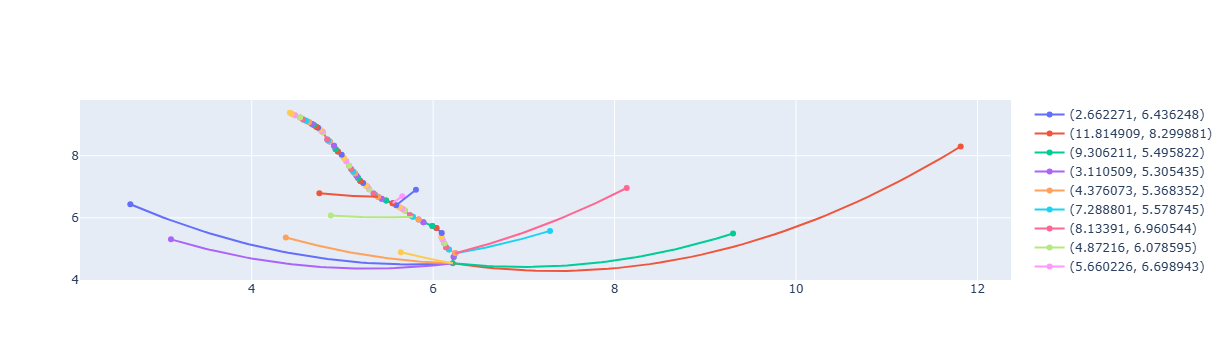

In [116]:
def total_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q):
    curve = curve_length(G, x1, y1, p, q)
    to_root = distance_from_base(root_distance, x0, y0, x1, y1)
    wiring = curve
    delay = (curve + to_root)
    cost = (alpha * wiring) +  ((1 - alpha) * delay)
    #print("curve = ", curve, "to root = " , to_root, "wiring = ", wiring, "delay = ", delay, "total cost = ", cost)
    #cost = curve + (1 - alpha) * distance_from_base(root_distance, x0, y0, x1, y1)
    return cost, wiring, delay

def is_between(a, x, b):
        return a < x < b or b < x < a

def valid_segments(tip_number, line_segments, closest_segs):
    valid_segs = []
    for num, seg in line_segments.items():
        x, y = seg[1]
        closest = closest_segs[tip_number]
        closest_y = closest[1][1]
        if y < closest_y:
            valid_segs.append(seg)
        else:
            break
    return valid_segs


# created helper function based on code above
def get_closest_main_seg(lat_tips, line_segments):
    closest_segs = []
    for tip in lat_tips: 
        best_distance = math.inf
        best_seg = None
        for num, seg in line_segments.items():
            d = math.inf
            x0, y0 = seg[0]
            x1, y1 = seg[1]

            A = (x0 - tip[0]) * (x1 - x0) + (y0 - tip[1]) * (y1 - y0)
            B = (x1 - x0)**2 + (y1 - y0)**2
            t = A/B
            if (0 <= t <= 1): 
                c = abs(((x1 - x0) * (y0 - tip[1])) - ((y1 - y0) * (x0 - tip[0])))
                d = c/math.sqrt(B)
            else: 
                d1 = math.sqrt((x1-tip[0])**2 + (y1 - tip[1])**2)
                d2 = math.sqrt((x0-tip[0])**2 + (y0 - tip[1])**2)
                d = min(d1, d2)
            if d < best_distance:
                best_distance = d
                best_seg = seg
        closest_segs.append(best_seg)
    return closest_segs

def get_closest_and_valid_segments(lat_tips, line_segments):
    all_closest = []
    all_valid_segs = []
    
    for tip in lat_tips: 
        best_distance = math.inf
        best_seg = None
        best_seg_num = None
        tip_x, tip_y = tip

        for num, seg in line_segments.items():
            x0, y0 = seg[0]
            x1, y1 = seg[1]

            A = (x0 - tip_x) * (x1 - x0) + (y0 - tip_y) * (y1 - y0)
            B = (x1 - x0)**2 + (y1 - y0)**2
            t = A / B if B != 0 else -1

            if 0 <= t <= 1:
                c = abs(((x1 - x0) * (y0 - tip_y)) - ((y1 - y0) * (x0 - tip_x)))
                d = c / math.sqrt(B)
            else:
                d1 = math.sqrt((x1 - tip_x) ** 2 + (y1 - tip_y) ** 2)
                d2 = math.sqrt((x0 - tip_x) ** 2 + (y0 - tip_y) ** 2)
                d = min(d1, d2)

            if d < best_distance:
                best_distance = d
                best_seg = seg
                best_seg_num = num

        all_closest.append(best_seg)

        # Collect valid segments (those before the closest one)
        valid = []
        for num, seg in line_segments.items():
            if seg[1][1] <= best_seg[1][1]:
                valid.append(seg)
            else:
                break
        all_valid_segs.append(valid)

    return all_closest, all_valid_segs
    
def find_best_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q):
    results = []
    min_t = 0
    delta = 0.01
    max_t = 1
    best_t = math.inf
    best_cost = math.inf
    best_wiring = math.inf
    best_delay = math.inf
    l = length_func(x0, y0, x1, y1)
    theta = get_theta(x0, y0, x1, y1)
    x_opt = None
    y_opt = None
    best_x = None
    best_y = None
    for t in pylab.arange(min_t, max_t + delta, delta):
        is_positive = positive_slope(x0, y0, x1, y1)
        new_x = None
        new_y = None
        if is_positive:
            new_x = x0 + t*l*math.cos(theta)
            new_y = y0 + t*l*math.sin(theta)
        else:
            new_x = x0 - (t*l*math.cos(theta))
            new_y = y0 + (t*l*math.sin(theta))
        x_curr = pylab.linspace(min(p, new_x), max(p, new_x))
        cost, wiring, delay = total_cost(alpha, G, root_distance, x0, y0, new_x, new_y, p, q)
        if cost <= best_cost:
            best_cost = cost
            best_wiring = wiring
            best_delay = delay
            best_t = t
            b, c = calc_coeff(G, new_x, new_y, p, q)
            best_x = new_x
            best_y = new_y
            #x_opt = x_curr
            #y_opt = G * x_opt ** 2 + b * x_opt + c
        '''
        if t % 0.2 == 0:
            b, c = calc_coeff(G, new_x, new_y, p, q)
            y_inter =  G * x_curr ** 2 + b * x_curr + c
            intermediate_line = go.Scatter(x = x_curr,y = y_inter, mode = "lines", name = str(cost))
            fig.add_trace(intermediate_line)
           '''
        results.append(cost)
    return best_cost, best_wiring, best_delay, best_t, best_x, best_y, p, q

def modified_arbor_best_cost(fname, alpha, G, root_distance):
    final = []
    arbor = rar.read_arbor_full(fname)
    point_drawing = go.Figure()
    main_root = []
    lat_tips = []
    line_segments = {}
    #point_drawing = go.Figure()
    for node in arbor.nodes():
        if arbor.nodes[node]["label"] == ("main root") or arbor.nodes[node]["label"] == ("main root base"):
            main_root.append(node)
        if arbor.nodes[node]["label"] == ("lateral root tip"):
            lat_tips.append(node)
    for i in range(1, len(main_root)):
        line_segments[i] = main_root[i - 1], main_root[i]

    #closest_segs = get_closest_main_seg(lat_tips, line_segments)
    tip_number = 0
    #closest_segs = []
    valid_segs = []
    closest_segs, all_valid_segs = get_closest_and_valid_segments(lat_tips, line_segments)
    for tip in lat_tips: 
        #print("Lateral root #: " + str(tip_number + 1))
        curr_dist = 0
        results = []
        valid_segs = all_valid_segs[tip_number]
        print(valid_segs)
        firstTime = True
        for seg in valid_segs: 
                
            x0, y0 = seg[0]
            x0_temp, y0_temp = seg[0]
            x0 -= x0
            y0 -= y0
            #print("Point 1: " + str(x0) + ", " + str(y0))
            x1, y1 = seg[1]
            x1 -= x0_temp
            y1 -= y0_temp
            #print("Point 2: " + str(x1) + ", " + str(y1))
            p, q = tip
            p -= x0_temp
            q -= y0_temp
            #print("Tip: " + str(p) + ", " + str(q))
            # if the tip is in between a segment, brute force the segment
            if is_between(x0, tip[0], x1):
                if firstTime == True:
                    result = find_best_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q)
                    curr_dist += length_func(x0, y0, x1, y1)
                    firstTime = False
                else:
                    result = find_best_cost(alpha, G, root_distance + curr_dist, x0, y0, x1, y1, p, q)
                    curr_dist += length_func(x0, y0, x1, y1)
                results.append(result)
                
            # if the tip is not in between a segment, use Dr. Richard's equation
            else:
                result = 0
                import math
                def cos(t):
                    return math.cos(t)
                def sin(t):
                    return math.sin(t)
                def sqrt(t):
                    return math.sqrt(t)
                
                l = math.sqrt((x1 - x0)**2 + (y1 - y0)**2)
                #print("Length is " + str(l))
                #theta = (math.pi)/3
                theta = get_theta(x0, y0, x1, y1)
                #print("Theta is " + str(theta))
                # Recalculate A1–E1 based on current l, theta, G, p, q
                A1=G*(l*cos(theta))**2
                B1=-l*sin(theta)
                C1=q-G*p**2
                D1=-l*cos(theta)
                E1=p
                #print(A1, B1, C1, D1, E1)
                # Define b(t), b'(t), cost'(t)
                def b(t): 
                    return (A1*t**2+B1*t+C1)/(D1*t+E1)
                def bprime(t):
                    return ((D1*t+E1)*(2*A1*t+B1)-D1*(A1*t**2+B1*t+C1))/(D1*t+E1)**2
                def costprime(t):
                    return (bprime(t)/(2*G))*(sqrt(1+(2*G*p+b(t))**2)-sqrt(1+(2*G*t*l*cos(theta)+b(t))**2))+(1-alpha)*l-sqrt(1+(2*G*t*l*cos(theta)+b(t))**2)*l*cos(theta)
                    

                import numpy as np
                import matplotlib.pyplot as plt
                
                #ts = np.linspace(0, 1, 100)
                #vals = [costprime(t) for t in ts]
                #plt.plot(ts, vals, label='costprime(t)')
                #plt.axhline(0, color='gray', linestyle='--')
                #plt.legend()
                #plt.show()
                def find_multiple_roots(func, x_range, num_guesses=100):
                    roots = []
                    guesses = np.linspace(x_range[0], x_range[1], num_guesses)
                    for guess in guesses:
                        try:
                            root = fsolve(func, guess)[0]
                            if not any(np.isclose(root, r) for r in roots):
                                roots.append(root)
                        except:
                            pass
                    return sorted(roots)
                import numpy as np
                from scipy.optimize import fsolve
                def f(x):
                    return costprime(x)
                # Find root(s) of costprime in [0, 1]
                roots = find_multiple_roots(f, [0, 1], num_guesses=10)
                #print("roots of costprime(x) =",roots)
                valid_roots = [r for r in roots if 0 <= r <= 1]
                #print(valid_roots)
            
                # Define the full cost function if not already
                def cost(t):
                    if is_positive:
                        end_segx = x0 + t*l*math.cos(theta)
                        end_segy = y0 + t*l*math.sin(theta)
                    else:
                        end_segx = x0 - (t*l*math.cos(theta))
                        end_segy = y0 + (t*l*math.sin(theta))
                    return total_cost(alpha, G, root_distance + curr_dist, x0, y0, end_segx, end_segy, p, q)[0]

                # reshift the points
                x0, y0 = seg[0]
                #print("Point 1: " + str(x0) + ", " + str(y0))
                x1, y1 = seg[1]
                is_positive = positive_slope(x0, y0, x1, y1)
                #print("Point 2: " + str(x1) + ", " + str(y1))
                p, q = tip
                
                # Get cost at valid root(s)
                if valid_roots:
                    #print(valid_roots)
                    min_root = min(valid_roots, key=lambda t: cost(t))
                    best_t = min_root
                    if is_positive:
                        best_x = x0 + best_t*l*math.cos(theta)
                        best_y = y0 + best_t*l*math.sin(theta)
                    else:
                        best_x = x0 - (best_t*l*math.cos(theta))
                        best_y = y0 + (best_t*l*math.sin(theta))
                    curve = curve_length(G, best_x, best_y, p, q)
                    to_root = distance_from_base(root_distance, x0, y0, best_x, best_y)
                    wiring = curve
                    delay = (curve + to_root)
                    result = (cost(min_root), wiring, delay, best_t, best_x, best_y, p, q)
                    curr_dist += length_func(x0, y0, x1, y1)
                else: 
                    # No root in [0,1], so check endpoints
                    cost_0 = cost(0)
                    cost_1 = cost(1)
                    if cost_0 < cost_1:
                        best_t = 0.0
                        best_x = x0
                        best_y = y0
                    else:
                        best_t = 1.0
                        best_x = x1
                        best_y = y1
                    #print(result)
                    curve = curve_length(G, best_x, best_y, p, q)
                    to_root = distance_from_base(root_distance, x0, y0, best_x, best_y)
                    wiring = curve
                    delay = (curve + to_root)
                    result = (min(cost_0, cost_1), wiring, delay, best_t, best_x, best_y, p, q)
                    curr_dist += length_func(x0, y0, x1, y1)
                    
                results.append(result)
        if results:
            final.append(min(results))
        else:
            print(f"Warning: No valid results for lateral tip #{tip_number} at {tip}")
            final.append(float('inf'))  # or some sentinel value       
        #final.append(min(results))
        tip_number += 1
    pq_drawings = get_tip_drawings(lat_tips)
    for p_and_q in pq_drawings:
        point_drawing.add_trace(p_and_q)
    
    segment_drawings = get_line_segment_drawings(line_segments)
    for line in segment_drawings:
        point_drawing.add_trace(line)

    opt_lines = get_opt_to_pq_drawings(G, final)
    for opt in opt_lines:
        point_drawing.add_trace(opt)
    point_drawing.show()
    
    return final

def graph_opt_lines(graph, final):
    for result in final:
        x0 = result[2]
        y0 = result[3]
        p = result[4]
        q = result[5]
        first_point = x0, y0
        second_point = p, q
        G = graph.graph['Gravity']
        b, c = calc_coeff(G, x0, y0, p, q)
        graph.add_node(first_point, pos=first_point)
        graph.add_node(second_point, pos=second_point)
        graph.add_edge(first_point, second_point, b = b, c = c)
    return graph
    
def get_line_segment_drawings(line_segments):
    segment_drawings = []
    for seg in line_segments:
        x0 = line_segments[seg][0][0]
        y0 = line_segments[seg][0][1] 
        x1 = line_segments[seg][1][0]
        y1 = line_segments[seg][1][1]

        xpoints = [x0, x1]
        ypoints = [y0, y1]

        segment = go.Scatter(x= xpoints, y=ypoints, name="segment")
        segment_drawings.append(segment)
    return segment_drawings

def get_tip_drawings(lat_tips):
    pq_drawings = []
    for tip in lat_tips:
        p = tip[0]
        q = tip[1]
        pq = go.Scatter(x = [p], y= [q], name= str(tip))
        pq_drawings.append(pq)
    return pq_drawings
    
def get_line_segments(arbor):
    line_segments = {}
    main_root = []
    for node in arbor.nodes():
        if arbor.nodes[node]["label"] == ("main root") or arbor.nodes[node]["label"] == ("main root base"):
            main_root.append(node)
    for i in range(1, len(main_root)):
        line_segments[i] = main_root[i - 1], main_root[i]
    return line_segments

def create_graphs(fname, alpha):
    G = rar.read_arbor_full(fname)
    G_opt = pf.opt_arbor(G, alpha)
    return G, G_opt

def get_opt_to_pq_drawings(gravity, final):
    drawings = []
    for result in final:
        if gravity == 0:
            x0 = result[4]
            y0 = result[5]
            p = result[6]
            q = result[7]
            xcoords = [p, x0]
            ycoords = [q, y0]
        
            line = go.Scatter(x=xcoords, y=ycoords, name = str(result[0]))
            drawings.append(line)
        else: 
            x0 = result[4]
            y0 = result[5]
            p = result[6]
            q = result[7]
            b, c = calc_coeff(gravity, x0, y0, p, q)
            x_opt = pylab.linspace(min(p, x0), max(p, x0))
            y_opt = gravity * x_opt ** 2 + b * x_opt + c
            line = go.Scatter(x=x_opt, y=y_opt, name = str(result[0]))
            drawings.append(line)
    return drawings
    
def graph_main_root(graph, line_segments):
     for seg in line_segments:
        x0 = line_segments[seg][0][0]
        y0 = line_segments[seg][0][1]
        x1 = line_segments[seg][1][0]
        y1 = line_segments[seg][1][1]
        first_point = x0, y0
        second_point = x1, y1


        graph.add_node(first_point, pos=first_point)
        graph.add_node(second_point, pos=second_point)
        graph.add_edge(first_point, second_point)
working = modified_arbor_best_cost('002_3_C_day5.csv', 0.4, 0.2, 0.0)

In [117]:
working
sum = 0
for calc in working:
    sum += calc[0]


old_sum = 0
for cost in old_method:
    old_sum += cost[0]
print(old_sum, sum)

32.9386422242997 32.93909872679719


In [ ]:
testing_graph = nx.Graph(G = 0.1)
graph_opt_lines(mygraph, working)
list(mygraph.edges(data = True))

1
2
3
4
5
6
7
8
9
10
11
12


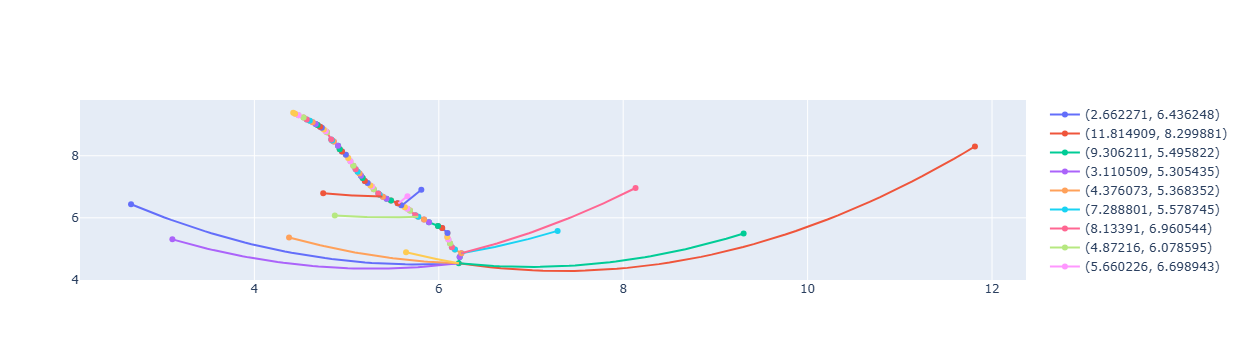

In [97]:
def arbor_best_cost(fname, alpha, G, root_distance):
    arbor = rar.read_arbor_full(fname)
    main_root = []
    lat_tips = []
    line_segments = {}
    point_drawing = go.Figure()
    for node in arbor.nodes():
        if arbor.nodes[node]["label"] == ("main root") or arbor.nodes[node]["label"] == ("main root base"):
            main_root.append(node)
        if arbor.nodes[node]["label"] == ("lateral root tip"):
            lat_tips.append(node)
    for i in range(1, len(main_root)):
        line_segments[i] = main_root[i - 1], main_root[i]

    # for each lateral root tip iterate through every line segment to find lowest costing point on main root
    final = []
    count = 1
    for tip in lat_tips:
        print(count)
        curr_dist = 0
        results = []
        firstTime = True
        p = tip[0]
        q = tip[1]
        for seg in line_segments:
            x0 = line_segments[seg][0][0]
            y0 = line_segments[seg][0][1]
            x1 = line_segments[seg][1][0]
            y1 = line_segments[seg][1][1]
            if firstTime == True:
                result = find_best_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q)
                curr_dist += length_func(x0, y0, x1, y1)
                firstTime = False
            else:
                result = find_best_cost(alpha, G, root_distance + curr_dist, x0, y0, x1, y1, p, q)
                curr_dist += length_func(x0, y0, x1, y1)
            results.append(result)
        final.append(min(results))
        count += 1
    pq_drawings = get_tip_drawings(lat_tips)
    for p_and_q in pq_drawings:
        point_drawing.add_trace(p_and_q)
    
    segment_drawings = get_line_segment_drawings(line_segments)
    for line in segment_drawings:
        point_drawing.add_trace(line)

    opt_lines = get_opt_to_pq_drawings(G, final)
    for opt in opt_lines:
        point_drawing.add_trace(opt)
    point_drawing.show()
    return final

old_method = arbor_best_cost('002_3_C_day5.csv', 0.4, 0.2, 0.0)

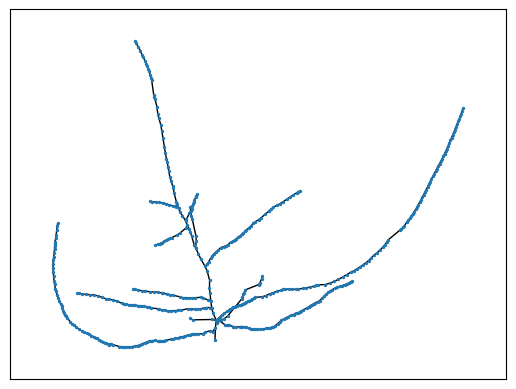

In [93]:
coords = {}
for coordinate in list(G.nodes):
    coords[coordinate] = coordinate
nx.draw_networkx(G, pos = coords, with_labels = False, node_size = 2)

In [99]:
dist = 0
for thing in old_method:
    main_root = thing[4], thing[5]
    lateral_tip = thing[6], thing[7]
    print(modified_fill_lateral_root(0.2, G, G_opt, main_root, lateral_tip))
    dist += modified_calculate_distance(0.2, G, G_opt, main_root, lateral_tip)
dist

([6.44464172727684, 6.460594736785058, 6.476610284749883, 6.487475307750821, 6.510190495727064, 6.518825220789836, 6.520007006239526, 6.521766966811838, 6.5316256563413715, 6.5487937367264415, 6.559728862469433, 6.565325030939841, 6.565146216933902, 6.561017636123532, 6.55008934464812, 6.535722201873948, 6.521266770049958, 6.49841308561587, 6.480105624903483, 6.4525581871579085, 6.413917822883635, 6.382266225886305, 6.349304797482725, 6.324392617688385, 6.302149241633545, 6.278435844898096, 6.251747156579301, 6.230962165392036, 6.207601995070553, 6.174205183093564, 6.09192725335461, 6.042318893860317, 6.000114293861047, 5.946308833862368, 5.878732719425681, 5.819917838445847, 5.75509259401783, 5.706137125918644, 5.652676231716615, 5.599567755266649, 5.555044813113865, 5.510150122880491, 5.479521623081899, 5.443142295172121, 5.404136482865619, 5.363926034614819, 5.338255587762459, 5.316873081565888, 5.271996843651111, 5.255470619143432, 5.236567349728162, 5.220387870308512, 5.1929143752

141.1971852925509

In [71]:
def modified_calculate_distance(gravity, G, G_opt, main_root, lateral_tip):
    opt_y_coords, actual_y_coords = modified_fill_lateral_root(gravity, G, G_opt, main_root, lateral_tip)
    distances = []

    for x in range(len(opt_y_coords)):
        diff_square = (opt_y_coords[x] - actual_y_coords[x]) ** 2
        distances.append(diff_square)
    return math.fsum(distances)

def modified_fill_lateral_root(gravity, G, G_opt, main_root, lateral_tip) :

    ## This method uses the lateral tip and main root to fill in points of the lateral root
    ## in order to perform distance calculation

    # get coefficients
    if gravity == 0:
        m, y_int = modified_line_equation(gravity, main_root, lateral_tip)
    else:
        b, c = modified_line_equation(gravity, main_root, lateral_tip)


    observed = {}
    optimal = {}
    observed, optimal = ps.create_dict(G, G_opt)
    backwards = {}

    ## reverses observed dictionary
    for node in reversed(observed):
        backwards[node] = observed[node]

    tip_found = False
    encountered_observed = []
    index = len(G.nodes) - 2

    ## loop backwards
    for node in backwards :
        if G.nodes[node]['label'] == "lateral root tip" and tip_found:
            break
        if lateral_tip == node:
            tip_found = True
           # print("tip was found")
            continue
        if tip_found == True and (list(G.nodes(data = True))[index][1]["label"] == "lateral root"):
           # print("not a tip")
            encountered_observed.append(node)
        index -= 1

    ## need to calculate points based on observed x-coordinates and line equation
    x_coords = []
    y_coords = []
    count = -1
    for point in encountered_observed:
        for coords in point:
          count += 1
          if count % 2 == 0 :
              x_coords.append(coords)
          else :
              y_coords.append(coords)
    added_nodes = []
    if gravity == 0:
        for x in x_coords:
            added_nodes.append(m * x + y_int)
    else:
        for x in x_coords:
            added_nodes.append(gravity*x*x + b*x + c)
    return added_nodes, y_coords

def modified_line_equation(G, main_root, lateral_tip):
    x, y = main_root
    p, q = lateral_tip
    if G == 0:
        m = (q - y) / (p - x)
        y_int = y - m * x
        return m, y_int
    else:
        b, c = calc_coeff(G, x, y, p, q)
        return b, c


In [106]:
G = rar.read_arbor_full('002_3_C_day5.csv')
G_opt = nx.Graph(Gravity = 0.2)
point_dist = 0
for sub in working:
    main_root = sub[4], sub[5]
    lateral_tip = sub[6], sub[7]
    print(modified_fill_lateral_root(0.2, G, G_opt, main_root, lateral_tip))
    point_dist += modified_calculate_distance(0.2, G, G_opt, main_root, lateral_tip)
point_dist

([6.43791719023307, 6.441129444887746, 6.444406236078674, 6.446658536771731, 6.451442958017686, 6.453288208448239, 6.453541885903031, 6.45392017440113, 6.456050291865502, 6.459804264556813, 6.462224573894509, 6.46347192201853, 6.463431974547888, 6.4625113106068595, 6.460089843218165, 6.45694091860838, 6.453812600289405, 6.448949624974944, 6.445128241685622, 6.439504732839991, 6.431878560808592, 6.425865322770443, 6.419833012776433, 6.415433118613153, 6.41162302631921, 6.407686621905624, 6.403414389119156, 6.400205505525271, 6.396725228627346, 6.391986872992294, 6.381554892072636, 6.376163036072652, 6.372137741921652, 6.367791746404608, 6.363652662603082, 6.361324492214806, 6.360232993249168, 6.360504213353028, 6.361952545863175, 6.364663421403482, 6.367980500180417, 6.372355456862447, 6.375969046972517, 6.380961956183016, 6.387208651666526, 6.394678377973882, 6.400027118563507, 6.404845430746063, 6.416092252927532, 6.420641772510681, 6.426129061316566, 6.431074278939034, 6.440019781586

439.19467814757775